0. Create a Model with division, death, and volume

In [1]:
%matplotlib inline
from bioscrape.lineage import LineageModel
from bioscrape.lineage import LineageVolumeSplitter
import numpy as np
import pylab as plt

#Define Rates
k = 1
d = .1
g = .2

#Define Reactions
rxn1 = (["A"], ["A", "X"], "massaction", {"k":k}) #A --> A + X @ k=k
rxn2 = (["A"], ["B"], "massaction", {"k":d}) #A --> B @ k=d
rxn3 = (["B"], ["A"], "massaction", {"k":d}) #B --> A @ k=d
rxns = [rxn1, rxn2, rxn3] #Define a list of all reactions

#Define initial condtion (as a dictionary)
x0 = {"X": 0, "A":1}
#Instantiate Model
LM1 = LineageModel(reactions = rxns, initial_condition_dict = x0)

#Add a volume event to the model (with a mass action propensity dependent on A). Causes the volume to grow linearly by the amount g when event fires.
LM1.create_volume_event("linear volume", {"growth_rate":g}, "massaction", {"k":.1, "species":"X"})

#Create a Volume Splitter which determines how species are partitioned at division
#species A and B will be duplicated (as if they were genomic) and X will by default be partitioned binomially
vsplit = LineageVolumeSplitter(LM1, options = {"A":"duplicate", "B":"duplicate"})

#Create two division rules, both use the same volume splitter
#1: cells divide when their volume increases by 5
LM1.create_division_rule("deltaV", {"threshold":5}, vsplit)
#Cells divide after 50 time units (since their last division)
LM1.create_division_rule("time", {"threshold":50}, vsplit)
#Create a death event with a positive hill function propensity H(X) = k / (1+(x/K)^n)
#LM1.create_death_event("death", {}, "hillpositive", {"s1":"X", "K":25, "n":2, "k":.25})
#Initialize the model (this also a)
LM1.py_initialize()

C:\Users\wp_ix\Miniconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: The follow species are uninitialized and their value has defaulted to 0: B, 


1. Testing SimulateCellLineage in the LineageSSASimulator

C:\Users\wp_ix\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: No initial state set (via LineageVolumeCellState v) in SingleCellSSAResuslt. Defaulting to the Model's initial state.
  


Total Cells Simulated 225


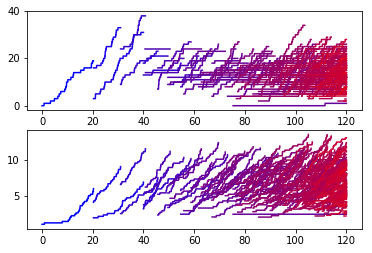

In [2]:
from bioscrape.lineage import py_SimulateCellLineage

max_time = 120
timepoints = np.linspace(0,max_time,max_time*100)

lineage = py_SimulateCellLineage(timepoints, Model = LM1)

sch_tree = [[]]
sch_tree_length = 1
for i in range(lineage.py_size()):
	sch = lineage.py_get_schnitz(i)
	if sch.py_get_parent() == None:
		sch_tree[0].append(sch)
	else:
		for j in range(len(sch_tree)):
			parent = sch.py_get_parent()
			if parent in sch_tree[j]:
				if len(sch_tree)<= j+1:
					sch_tree.append([])
					sch_tree_length += 1
				sch_tree[j+1].append(sch)

color_list = []
for i in range(sch_tree_length):
	color_list.append((i/sch_tree_length, 0, 1.-i/sch_tree_length))

#X_ind = LM1.get_species_index('X')
plt.figure()
plt.subplot(211)
count = 0
for i in range(sch_tree_length):
    for sch in sch_tree[i]:
        df = sch.py_get_dataframe(Model = LM1)
        count+=1
        plt.plot(df["time"], df["X"], color = color_list[i])


plt.subplot(212)
for i in range(sch_tree_length):
    for sch in sch_tree[i]:
        df = sch.py_get_dataframe(Model = LM1)
        plt.plot(df["time"], df["volume"], color = color_list[i])

print("Total Cells Simulated", count)

plt.show()


Testing the LineageSSASimulator PropogateCells Function

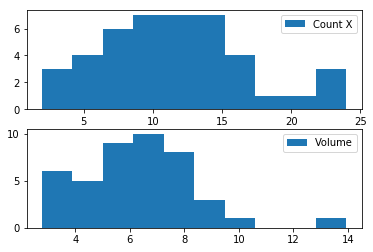

In [3]:
%matplotlib inline

from bioscrape.lineage import py_PropagateCells

max_time = 120
timepoints = np.linspace(0,max_time,max_time*100)
final_states = py_PropagateCells(timepoints, Model = LM1)


plt.figure()
plt.subplot(211)
plt.hist(final_states["X"], label = "Count X")
plt.legend()
plt.subplot(212)
plt.hist(final_states["volume"], label = "Volume")
plt.legend()

plt.show()

3. Testing Single Cell Lineage Simulation

C:\Users\wp_ix\Miniconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


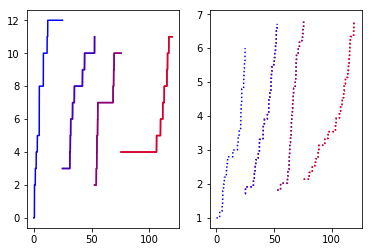

In [4]:
from bioscrape.lineage import py_SingleCellLineage

max_time = 120
timepoints = np.linspace(0,max_time,max_time*100)
final_lineage = py_SingleCellLineage(timepoints, Model = LM1)

lineage_size = len(final_lineage)
volumes=[]
plt.figure()
color_list = [(i/lineage_size, 0, 1-i/lineage_size) for i in range(lineage_size)]
for i in range(lineage_size):
    f = final_lineage[i]
    plt.subplot(121)
    plt.plot(f["time"], f["X"], color = color_list[i])
    plt.subplot(122)
    plt.plot(f["time"], f["volume"], ":", color = color_list[i])

plt.show()